# Spectral response of a nonlinear Jaynes-Cummings model

Here we will show the numerical simulation of the system, and a comparison with the analytical¹ expressions

The full-Hamiltonian in consideration to simulate is defined as
$$
\begin{equation}
    \hat H^{D}_{\texttt{JC}}\!=\!\frac{\hbar\omega_{c}}{2}(\hat{A}^{\dagger}\hat{A}+\hat{A} \hat{A}^{\dagger}) + \frac{\hbar\omega_a}{2}\hat{\sigma}_{z}\!-\mathrm{i}\frac{\hbar\Omega_{0}}{2}(\hat{A}\hat{\sigma}_{+}\!-\!\hat{A}^{\dagger} \hat{\sigma}_{-}),
\end{equation}
$$
where $\hat{A} = \hat{a}f(\hat{n})$ the new _deformed_ annihilation operator, that uses the _deformation function_ $f^2(\hat{n})=1+\chi\hat{n}$, for some parameter $\chi$ that acts a deformation strength.

Algorithmically, we define the deformed operators, then the Hamiltonian is obtained to obtain a evolution operator. This evolution operator is used to translate the operators in the two-time correlation function, and then the numerical integration of this correlation function is performed. The result is the frequency spectrum from $0$ to $t_{\mathrm{obs}}$.
_____
¹In a strict way, we do a semi-analytical approach, since we obtain the analytical two-time correlation functions, and then we numerically integrate this expression in order to obtain the frequency-dependent spectrum at time $t$

In [1]:
# Python and Qutip packages

from qutip import *
import qutip as qp
import numpy as np
import scipy as spy

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

In [2]:
# Number of photons in the field

nn = 0
alpha = 2

In [3]:
# Frequencies and relevant parameters

# Approximate resonance
""" omega_a = 1.0
omega_c = 0.9
Omega_0 = 0.25
chi = 0.01852 """

# Exact resonance
""" Omega_0 = 0.25
omega_a = 1.0
chi = 0.2 #Omega_0/1.0
omega_c = omega_a/(1 + 2 * chi * (nn + 1)) """

# DVRS
omega_a = 1.0
omega_c = 0.8 * omega_a
Omega_0 = 0.25 * omega_a
chi = 0.25

Gamma = 0.01

In [7]:
delta = omega_a - omega_c
delta

0.19999999999999996

In [4]:
# Rabi cycles

def tau(nn):
    return (2 * np.pi)/(Omega_0 * np.sqrt(nn + 1))

In [6]:
# Time and frequency dimensionality

tspan = 300
tlim = 8 * tau(nn)

omegaspan = 300
olim_l = 0.0
olim_r = 2.0

tlist = np.linspace(0, tlim, tspan, endpoint = True)
omegalist = np.linspace(olim_l, olim_r, omegaspan, endpoint = True)

In [5]:
# Fock and spin space dimensionality

N = 15
s = 2 # fixed for spin-1/2

In [8]:
# Field and atomic operators

a = destroy(N)
n = num(N)

sz = sigmaz()
sm = sigmam()
sp = sigmap()

In [9]:
# JC deformed Hamiltonian

f = qp.Qobj.sqrtm(1 + chi * n)

A = a * f

#

H = (omega_c/2.0) * tensor(A.dag() * A + A * A.dag(), qeye(s)) + (omega_a/2.0) * tensor(qeye(N), sz) - 1j * (Omega_0/2.0) * (tensor(A, sp) - tensor(A.dag(), sm))

In [10]:
# Initial state ket. Field (n or alpha) times atom (up)

psi0 = tensor(fock(N, nn), basis(s, 0))
#psi0 = tensor(coherent(N, alpha), basis(s, 0))

In [11]:
# Propagator U

U = propagator(H, tlist, opts = Options(order = 12, nsteps = int(100000)), unitary_mode = 'batch')

/usr/local/lib64/python3.9/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [12]:
# Two-time two-operators correlation

corr = np.zeros((tspan, tspan), dtype = complex)

for i in range(0, tspan):
    for j in range(0, tspan):
        corr[i, j] = (psi0.dag() * U[i].dag() * tensor(qeye(N), sp) * U[i] * U[j].dag() * tensor(qeye(N), sm) * U[j] * psi0)

In [13]:
(np.sum(np.real(corr)), np.sum(np.imag(corr)))

(3.1050093586954137, 9.769962616701378e-15)

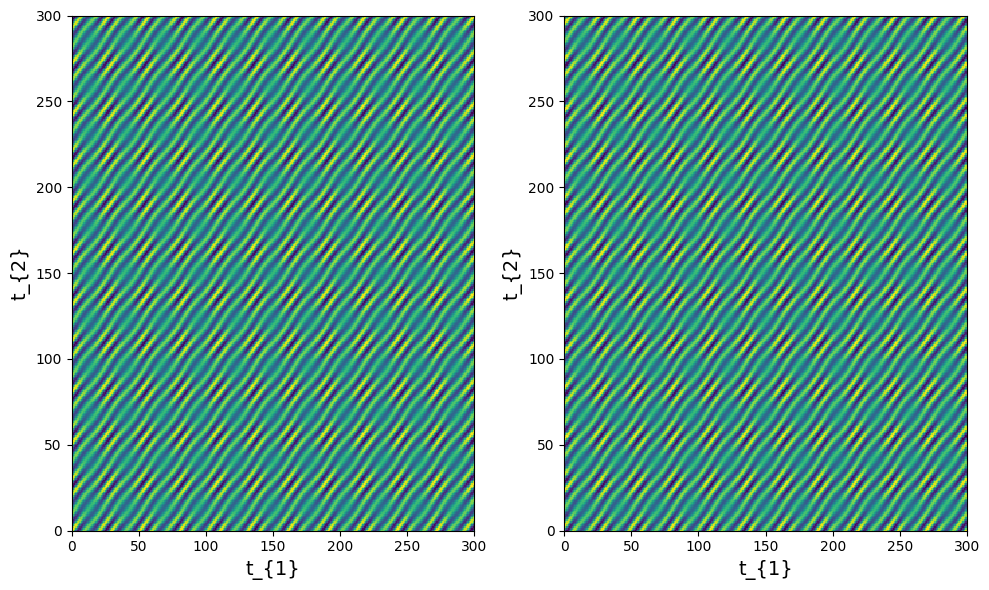

In [14]:
# Correlation function plot

fcorr, axcorr = plt.subplots(1, 2, figsize = (10, 6))

axcorr[0].pcolor(np.real(corr))
axcorr[1].pcolor(np.imag(corr))

axcorr[0].set_xlabel("t_{1}", fontsize = 14)
axcorr[0].set_ylabel("t_{2}", fontsize = 14)
axcorr[1].set_xlabel("t_{1}", fontsize = 14)
axcorr[1].set_ylabel("t_{2}", fontsize = 14)

plt.tight_layout()

In [15]:
# Integrand of the spectrum

def E(i, j, omega):
    return np.exp((Gamma - 1j * omega) * tlist[i]) * np.exp((Gamma + 1j * omega) * tlist[j])

In [16]:
# Constructor of the integrand times the correlation function. In terms of omega

def Eint(omega):
    EM = np.zeros((tspan, tspan), dtype = complex)
    for i in range(0, tspan):
        for j in range(0, tspan):
            EM[i, j] = E(i, j, omega) * corr[i, j]

    return EM

In [17]:
# Frequency omega space

Eomega = [Eint(omegalist[k]) for k in range(0, len(omegalist))];

In [18]:
# Integration

Sm = [2 * Gamma * np.exp(-2 * Gamma * tlist[tspan - 1]) * np.trapz(np.trapz(Eomega[k], tlist), tlist) for k in range(0, len(omegalist))]

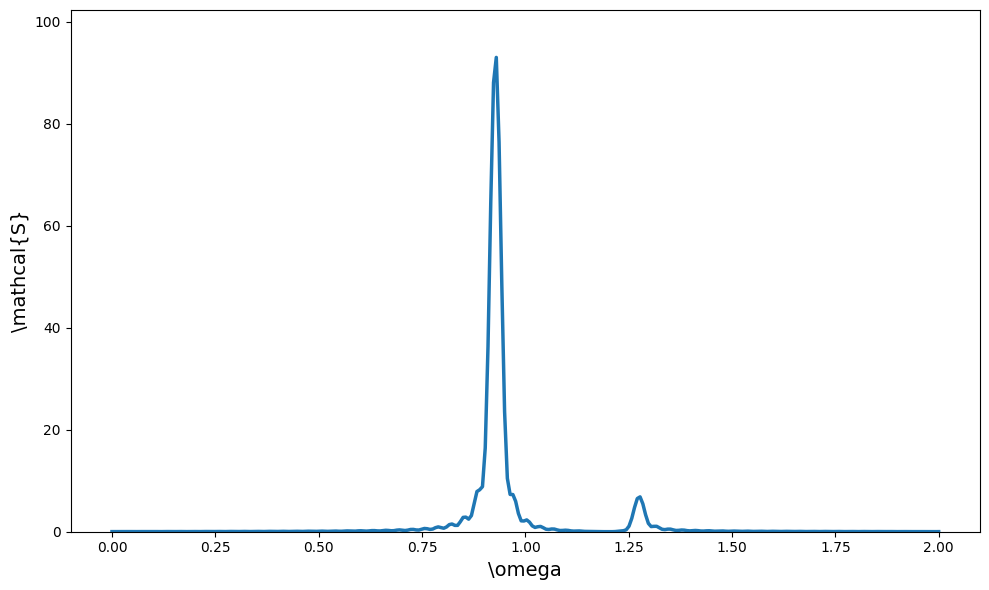

In [19]:
# EW spectrum plot

fS = plt.figure(figsize = (10, 6))
axS = plt.gca()

axS.plot(omegalist, np.real(Sm), lw = 2.5)
axS.set_ylim(0, max(1.1 * np.real(Sm)))
axS.set_xlabel("\omega", fontsize = 14)
axS.set_ylabel("\mathcal{S}", fontsize = 14)

plt.tight_layout()

___

## Comparison between numerical results and analytical findings

For the case, a Python module¹ containing the expression for the correlation functions is implemented apart. There, the functions used Gcorr_n for number states, and Gcorr_a for coherent states can be used. A recycle of the above routines for numerical computation of the expression is used.
_____
¹Search for _EW_DJC_analytical_corrfuncs.py_ in the working directory

In [20]:
# Import the ad-hoc Python module

import EW_DJC_analytical_corrfuncs as efuncs
#from importlib import reload 
#reload(EW_DJC_analytical_corrfuncs)

In [21]:
# Two-time two-operators correlation

acorr = np.zeros((tspan, tspan), dtype = complex)

for i in range(0, tspan):
    for j in range(0, tspan):
        acorr[i, j] = efuncs.Gcorr_n(omega_a, omega_c, Omega_0, chi, nn, tlist[i], tlist[j])

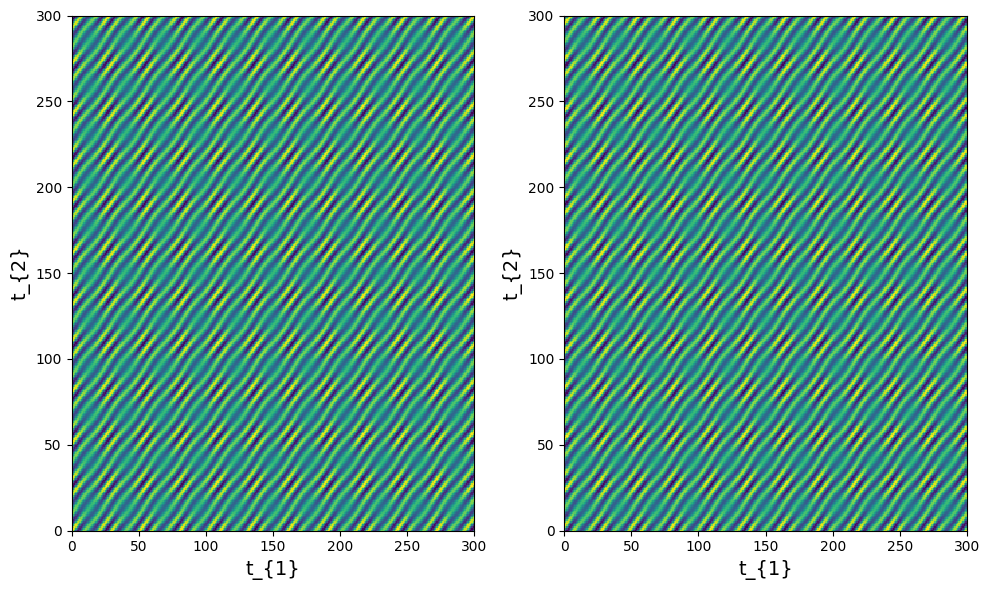

In [22]:
# Correlation function plot

afcorr, axacorr = plt.subplots(1, 2, figsize = (10, 6))

axacorr[0].pcolor(np.real(acorr))
axacorr[1].pcolor(np.imag(acorr))

axacorr[0].set_xlabel("t_{1}", fontsize = 14)
axacorr[0].set_ylabel("t_{2}", fontsize = 14)
axacorr[1].set_xlabel("t_{1}", fontsize = 14)
axacorr[1].set_ylabel("t_{2}", fontsize = 14)

plt.tight_layout()

In [23]:
def aEint(omega):
    aEM = np.zeros((tspan, tspan), dtype = complex)
    for i in range(0, tspan):
        for j in range(0, tspan):
            aEM[i, j] = E(i, j, omega) * acorr[i, j]

    return aEM

aEomega = [aEint(omegalist[k]) for k in range(0, len(omegalist))];

aSm = [2 * Gamma * np.exp(-2 * Gamma * tlist[tspan - 1]) * np.trapz(np.trapz(aEomega[k], tlist), tlist) for k in range(0, len(omegalist))]

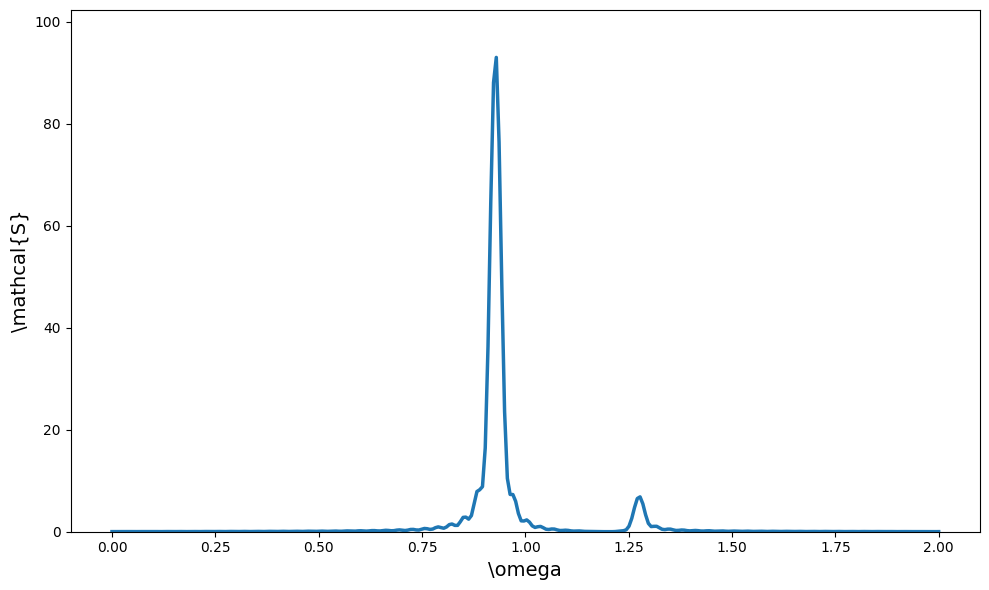

In [24]:
# EW spectrum plot

afS = plt.figure(figsize = (10, 6))
aaxS = plt.gca()

aaxS.plot(omegalist, np.real(aSm), lw = 2.5)
aaxS.set_ylim(0, max(1.1 * np.real(Sm)))
aaxS.set_xlabel("\omega", fontsize = 14)
aaxS.set_ylabel("\mathcal{S}", fontsize = 14)

plt.tight_layout()

---